# Wine Quality

![](https://www.wine-searcher.com/images/news/74/12/faves1-10007412.jpg)

## Imports

In [ ]:
import os,re,zipfile
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('dark_background')
plt.style.use('seaborn')
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn import metrics
import xgboost as xgb

## Data

- fixed acidity 
- volatile acidity 
- citric acid 
- residual sugar 
- chlorides 
- free sulfur dioxide 
- total sulfur dioxide 
- density 
- pH 
- sulphates 
- alcohol 
Output variable (based on sensory data): 
- quality (score between 0 and 10)
- type 1/0 (red/white)

In [ ]:
red = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv',sep=';')
red['type'] = 1
white = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv',sep=';')
white['type'] = 0
df = pd.concat([red,white],ignore_index=True)
df.columns = ['_'.join(x.split()) for x in df.columns.str.lower()]
df[:3]

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol,quality,type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,1


## EDA

**number of wine samples by quality**

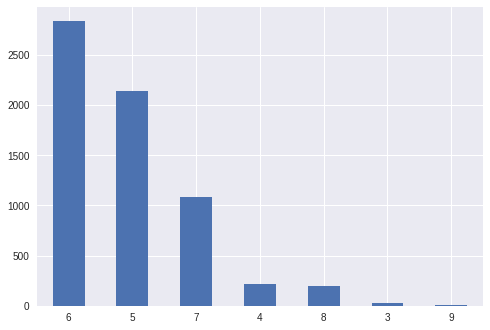

In [ ]:
df.quality.value_counts().plot.bar(rot=0)

**Average features by quality**

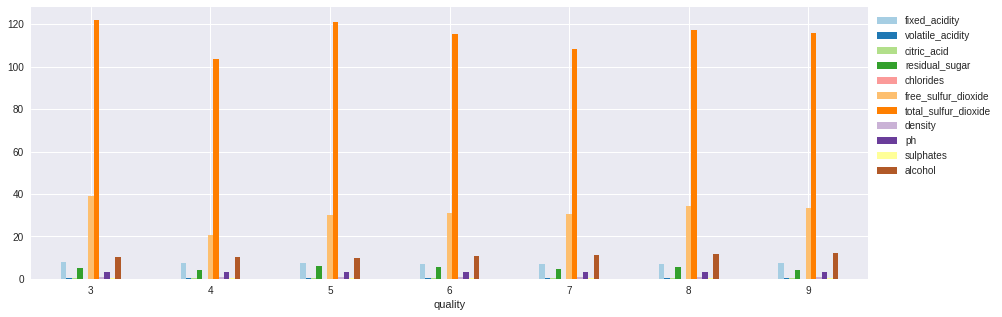

In [ ]:
df.groupby('quality').agg({
    'fixed_acidity': 'mean', 
    'volatile_acidity': 'mean', 
    'citric_acid': 'mean', 
    'residual_sugar': 'mean',
    'chlorides': 'mean', 
    'free_sulfur_dioxide': 'mean', 
    'total_sulfur_dioxide': 'mean', 
    'density': 'mean', 
    'ph': 'mean', 
    'sulphates': 'mean', 
    'alcohol': 'mean',
}).plot.bar(rot=0,figsize=(15,5),cmap='Paired').legend(bbox_to_anchor=(1.0,1.0))

## Predicting Wine Quality

![](https://hospitality-school.com/wp-content/uploads/2014/02/wine-tasting-procedure.jpg)

**Split the data into Train & Test**

In [ ]:
train,test = train_test_split(df,test_size=0.33, random_state=42,stratify=df.quality)

**Feature columns**

In [ ]:
x_cols = [
        'fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar','chlorides', 
        'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density','ph', 'sulphates', 'alcohol', 'type'
       ]

**Grid Search Parameters Search**

In [ ]:
param_grid = {
    # "learning_rate"    : [0.05, 0.10 ] ,
    "max_depth"        : [ 1, 4, 7, 14, 20],
    # "min_child_weight" : [ 3, 5, 7 ],
    # "gamma"            : [ 0.1, 0.3],
    "colsample_bytree" : [ 0.3, 0.5 , 0.7 ],
    "n_estimators" : [ 1000 ],
    "objective": ['binary:logistic','multi:softmax','multi:softprob'],
    "num_class": [df.quality.nunique()]
 }

**XGBoost Classifier + Hyper-Parameters Tunning**

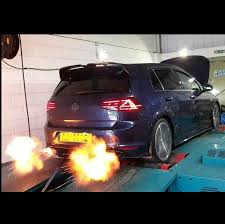

**Search**

In [ ]:
xgc = xgb.XGBClassifier()
grid = GridSearchCV(xgc, param_grid, cv=2,verbose=10,n_jobs=-1)
grid.fit(train[x_cols],train['quality'])

**Already searched the best**

In [ ]:
best_params = {
    'colsample_bytree': 0.5,
    'max_depth': 20,
    'n_estimators': 1000,
    'num_class': 7,
    'objective': 'binary:logistic'
 }
xgc = xgb.XGBClassifier(**best_params)
xgc.fit(train[x_cols],train['quality'])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=20,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
              nthread=None, num_class=7, objective='multi:softprob',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=1, verbosity=1)

**Feature importance**

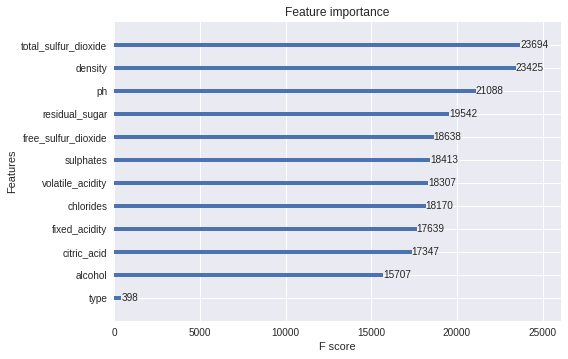

In [ ]:
xgb.plot_importance(xgc)

**Results**

In [ ]:
results = pd.DataFrame({
    'y_pred': xgc.predict(test[x_cols]),
    'y_true': test['quality']})
results

,y_pred,y_true
5783,7,7
2962,5,4
1384,5,5
5905,6,6
3083,5,3
...,...,...
4066,6,6
1083,6,6
398,6,6
306,5,5


**Classification Report**

In [ ]:
print(metrics.classification_report(results.y_true,results.y_pred))

              precision    recall  f1-score   support

           3       0.00      0.00      0.00        10
           4       0.44      0.17      0.24        71
           5       0.71      0.69      0.70       706
           6       0.65      0.74      0.70       936
           7       0.64      0.60      0.62       356
           8       0.88      0.36      0.51        64
           9       0.00      0.00      0.00         2

    accuracy                           0.67      2145
   macro avg       0.48      0.37      0.40      2145
weighted avg       0.66      0.67      0.66      2145



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Anomaly Detection

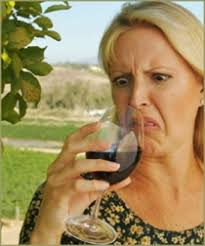

In [ ]:
from sklearn.ensemble import IsolationForest

**Columns to search for anomalies**

In [ ]:
x_cols = [
        'fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar','chlorides', 
        'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density','ph', 'sulphates', 'alcohol'
       ]

**Anomalies dataframe**

In [ ]:
%%time
adf = df.copy()
adf['anomalies'] = IsolationForest(random_state=0,n_estimators=1000,n_jobs=-1).fit_predict(adf[x_cols])
adf[:3]

CPU times: user 4.53 s, sys: 255 ms, total: 4.79 s
Wall time: 4.3 s


**Total Anoamlies**

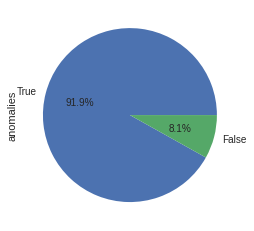

In [ ]:
(adf.anomalies.value_counts() / adf.anomalies.value_counts().sum()).rename(index={1:True,-1:False}).plot.pie(autopct='%1.1f%%')

In [ ]:
adf.groupby(['anomalies','type','quality']).agg({x:'mean' for x in x_cols})#.style.background_gradient(cmap='Blues')

fixed_acidity  volatile_acidity  ...  sulphates    alcohol
anomalies type quality                                   ...                      
-1        0    3             8.487500          0.353750  ...   0.527500  10.162500
               4             7.791667          0.630417  ...   0.487500  10.341667
               5             7.231507          0.340137  ...   0.513014   9.487671
               6             7.312676          0.308873  ...   0.536761  10.210563
               7             5.419048          0.375476  ...   0.641429  12.921429
               8             5.200000          0.318333  ...   0.676667  12.688889
          1    3             8.700000          0.888125  ...   0.565000   9.987500
               4             7.500000          0.822750  ...   0.666500  10.530000
               5             9.346491          0.625263  ...   0.764298  10.075000
               6             9.688372          0.509496  ...   0.769302  10.820930
               7             9.648214          0.463393  ...   0.787857  11.638690
               8             8.383333          0.501667  ...   0.785000  12.783333
 1        0    3             7.008333          0.319583  ...   0.439167  10.466667
               4             7.076821          0.361424  ...   0.475232  10.137417
               5             6.918280          0.300000  ...   0.480578   9.825780
               6             6.821815          0.258952  ...   0.489582  10.587549
               7             6.766880          0.260012  ...   0.499721  11.329957
               8             6.736145          0.275181  ...   0.475904  11.578916
               9             7.420000          0.298000  ...   0.466000  12.180000
          1    3             7.000000          0.870000  ...   0.590000   9.825000
               4             7.948485          0.615909  ...   0.553939  10.104545
               5             7.930159          0.567346  ...   0.592152   9.864462
               6             8.007269          0.494440  ...   0.651513  10.581009
               7             8.568531          0.380629  ...   0.723007  11.398252
               8             8.658333          0.384167  ...   0.759167  11.750000

[25 rows x 11 columns]